# Libraries

In [1]:
from pathlib import Path

from anomalib.data.utils import read_image
from anomalib.deploy import OpenVINOInferencer
from pytorch_lightning import Trainer
from pytorch_lightning.callbacks import ModelCheckpoint

import os
from PIL import Image

# Data Preparation

## Converting from JPG to png

In [2]:
source_directory = "./pcb3/Data/Images/Anomaly/"
destination_directory = "./pcb3/anomaly_png/"

# Create the destination directory if it doesn't exist
if not os.path.exists(destination_directory):
    os.makedirs(destination_directory)

# Iterate over the files in the source directory
for filename in os.listdir(source_directory):
    if filename.endswith(".JPG"):
        # Open the image file
        image_path = os.path.join(source_directory, filename)
        image = Image.open(image_path)

        # Convert and save the image as .png in the destination directory
        new_filename = os.path.splitext(filename)[0] + ".png"
        destination_path = os.path.join(destination_directory, new_filename)
        image.save(destination_path, "PNG")

        print(f"Converted {filename} to {new_filename} and saved to {destination_directory}")

In [3]:
source_directory = "./pcb3/Data/Images/Normal"
destination_directory = "./pcb3/normal_png/"

# Create the destination directory if it doesn't exist
if not os.path.exists(destination_directory):
    os.makedirs(destination_directory)

# Iterate over the files in the source directory
for filename in os.listdir(source_directory):
    if filename.endswith(".JPG"):
        # Open the image file
        image_path = os.path.join(source_directory, filename)
        image = Image.open(image_path)

        # Convert and save the image as .png in the destination directory
        new_filename = os.path.splitext(filename)[0] + ".png"
        destination_path = os.path.join(destination_directory, new_filename)
        image.save(destination_path, "PNG")

        print(f"Converted {filename} to {new_filename} and saved to {destination_directory}")

## Dataset: pcb1

In [4]:
from anomalib.data.folder import Folder
from anomalib.data.task_type import TaskType

datamodule = Folder(
    root=Path.cwd() / "pcb3",
    normal_dir="normal_png",
    abnormal_dir="anomaly_png",
    normal_split_ratio=0.2,
    image_size=(256, 256),
    train_batch_size=32,
    eval_batch_size=32,
    task=TaskType.CLASSIFICATION,
)
datamodule.setup()  # Split the data to train/val/test/prediction sets.
datamodule.prepare_data()  # Create train/val/test/predic dataloaders

i, data = next(enumerate(datamodule.val_dataloader()))
print(data.keys())

dict_keys(['image_path', 'label', 'image'])


In [5]:
# Check image size
print(data["image"].shape)

torch.Size([32, 3, 256, 256])


# Model: Cflow, Backbone: ResNet-18

## Prepare the Model

In [6]:
from anomalib.models import Cflow

model = Cflow(
    input_size=(256, 256),
    backbone="resnet18",
    layers=["layer1", "layer2", "layer3"],
)

C:\Users\Stellar\AppData\Roaming\Python\Python310\site-packages\torchmetrics\utilities\prints.py:36: DeprecationWarning: From v0.10 an `'Binary*'`, `'Multiclass*', `'Multilabel*'` version now exist of each classification metric. Moving forward we recommend using these versions. This base metric will still work as it did prior to v0.10 until v0.11. From v0.11 the `task` argument introduced in this metric will be required and the general order of arguments may change, such that this metric will just function as an single entrypoint to calling the three specialized versions.
  warnings.warn(*args, **kwargs)
C:\Users\Stellar\AppData\Roaming\Python\Python310\site-packages\torchmetrics\utilities\prints.py:36: UserWarning: Metric `PrecisionRecallCurve` will save all targets and predictions in buffer. For large datasets this may lead to large memory footprint.
  warnings.warn(*args, **kwargs)
FeatureExtractor is deprecated. Use TimmFeatureExtractor instead. Both FeatureExtractor and TimmFeatur

## Prepare the Callbacks

In [7]:
from anomalib.data.folder import Folder
from anomalib.data.task_type import TaskType

from anomalib.post_processing import NormalizationMethod, ThresholdMethod
from anomalib.utils.callbacks import (
    MetricsConfigurationCallback,
    MinMaxNormalizationCallback,
    PostProcessingConfigurationCallback,
)
from anomalib.utils.callbacks.export import ExportCallback, ExportMode

callbacks = [
    MetricsConfigurationCallback(
        task=TaskType.CLASSIFICATION,
        image_metrics=["AUROC", "AUPR"]
    ),
    ModelCheckpoint(
        mode="max",
        monitor="image_AUROC",
        \
    ),
    PostProcessingConfigurationCallback(
        normalization_method=NormalizationMethod.MIN_MAX,
        threshold_method=ThresholdMethod.ADAPTIVE,
    ),
    MinMaxNormalizationCallback(),
    ExportCallback(
        input_size=(256, 256),
        dirpath=str(Path.cwd()),
        filename="model",
        export_mode=ExportMode.OPENVINO,
    ),
]

## Training

In [8]:
trainer = Trainer(
    callbacks=callbacks,
    accelerator="auto",
    auto_scale_batch_size=False,
    check_val_every_n_epoch=1,
    devices=1,
    gpus=None,
    max_epochs=10,
    num_sanity_val_steps=0,
    val_check_interval=1.0,
)
trainer.fit(model=model, datamodule=datamodule)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer(val_check_interval=1.0)` was configured so validation will run at the end of the training epoch..
Missing logger folder: C:\Users\Stellar\Jupyter Notebook Mambaforge\Machine Learning 3\group_proj\pcb3_cflow\lightning_logs
C:\Users\Stellar\AppData\Roaming\Python\Python310\site-packages\torchmetrics\utilities\prints.py:36: DeprecationWarning: From v0.10 an `'Binary*'`, `'Multiclass*', `'Multilabel*'` version now exist of each classification metric. Moving forward we recommend using these versions. This base metric will still work as it did prior to v0.10 until v0.11. From v0.11 the `task` argument introduced in this metric will be required and the general order of arguments may change, such that this metric will just function as an single entrypoint to calling the three specialized versions.
  warnings.warn(*args, **kwargs)
C:\Us

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

C:\Users\Stellar\AppData\Roaming\Python\Python310\site-packages\torchmetrics\utilities\prints.py:36: DeprecationWarning: `torchmetrics.functional.auc` has been move to `torchmetrics.utilities.compute` in v0.10 and will be removed in v0.11.
  warnings.warn(*args, **kwargs)


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.
C:\Users\Stellar\AppData\Roaming\Python\Python310\site-packages\anomalib\models\cflow\torch_model.py:80: TracerWarning: torch.Tensor results are registered as constants in the trace. You can safely ignore this warning if you use this function to create tensors out of constant variables that would be the same every time you call this function. In any other case, this might cause the trace to be incorrect.
  distribution = [torch.Tensor(0).to(images.device) for _ in self.pool_layers]
C:\Users\Stellar\AppData\Roaming\Python\Python310\site-packages\anomalib\models\cflow\torch_model.py:107: TracerWarning: Converting a tensor to a Python integer might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  fiber_batches = embedding_length // self.fiber_batch_size + int(
C:\Users\Stellar\AppData\Ro

================ Diagnostic Run torch.onnx.export version 2.0.0 ================
verbose: False, log level: Level.ERROR
======================= 0 NONE 0 NOTE 0 WARNING 0 ERROR ========================



## Evaluation

In [9]:
# Validation
test_results = trainer.test(model=model, datamodule=datamodule)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│        image_AUPR         │    0.47165143489837646    │
│        image_AUROC        │    0.6893069744110107     │
└───────────────────────────┴───────────────────────────┘

## Inference using OpenVino

### Load a Test Image

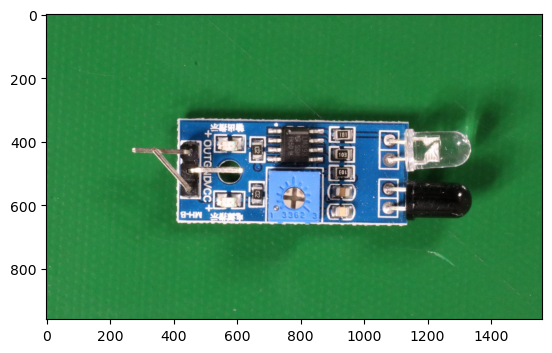

In [10]:
from matplotlib import pyplot as plt

image_path = "./pcb3/anomaly_png/000.png"
image = read_image(path="./pcb3/anomaly_png/000.png")
plt.imshow(image)

### Load OpenVINO Model

In [11]:
openvino_model_path = Path.cwd() / "weights" / "openvino" / "model.bin"
metadata_path = Path.cwd() / "weights" / "openvino" / "metadata.json"
print(openvino_model_path.exists(), metadata_path.exists())

True True


In [12]:
inferencer = OpenVINOInferencer(
    path=openvino_model_path,  # Path to the OpenVINO IR model.
    metadata=metadata_path,  # Path to the metadata file.
    device="CPU",  # We would like to run it on an Intel CPU.
)

### Perform Inference

In [13]:
print(image.shape)
predictions = inferencer.predict(image=image)

(960, 1562, 3)


### Visualizing Inference Results

#### Example 1

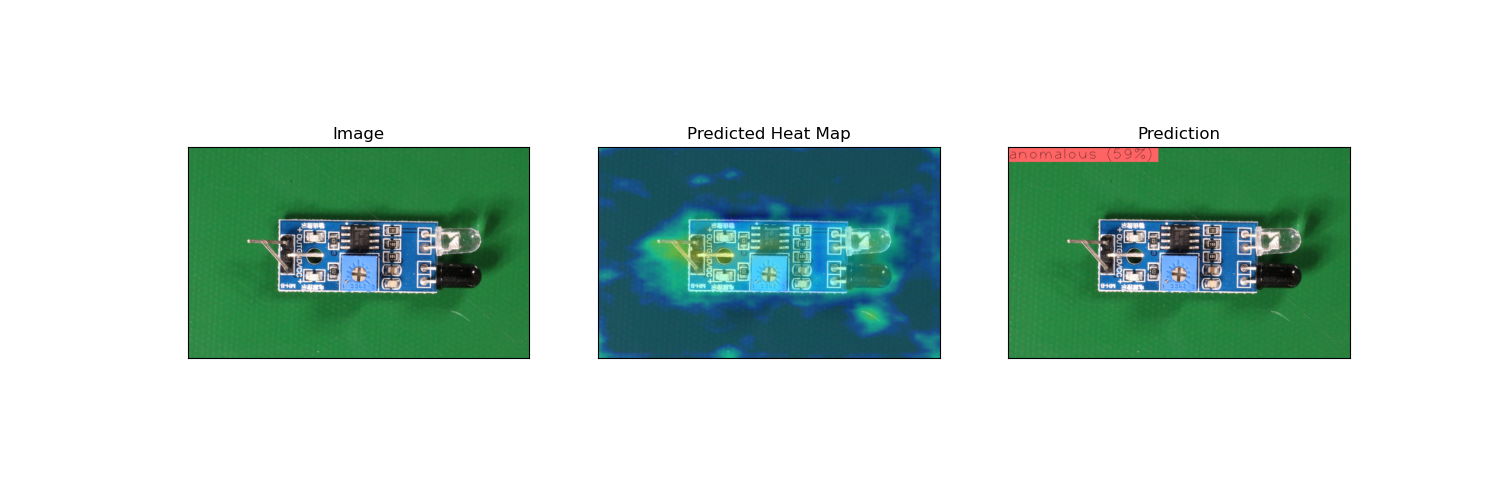

In [14]:
from anomalib.post_processing import Visualizer, VisualizationMode
from PIL import Image

visualizer = Visualizer(mode=VisualizationMode.FULL, task=TaskType.CLASSIFICATION)
output_image = visualizer.visualize_image(predictions)
Image.fromarray(output_image)

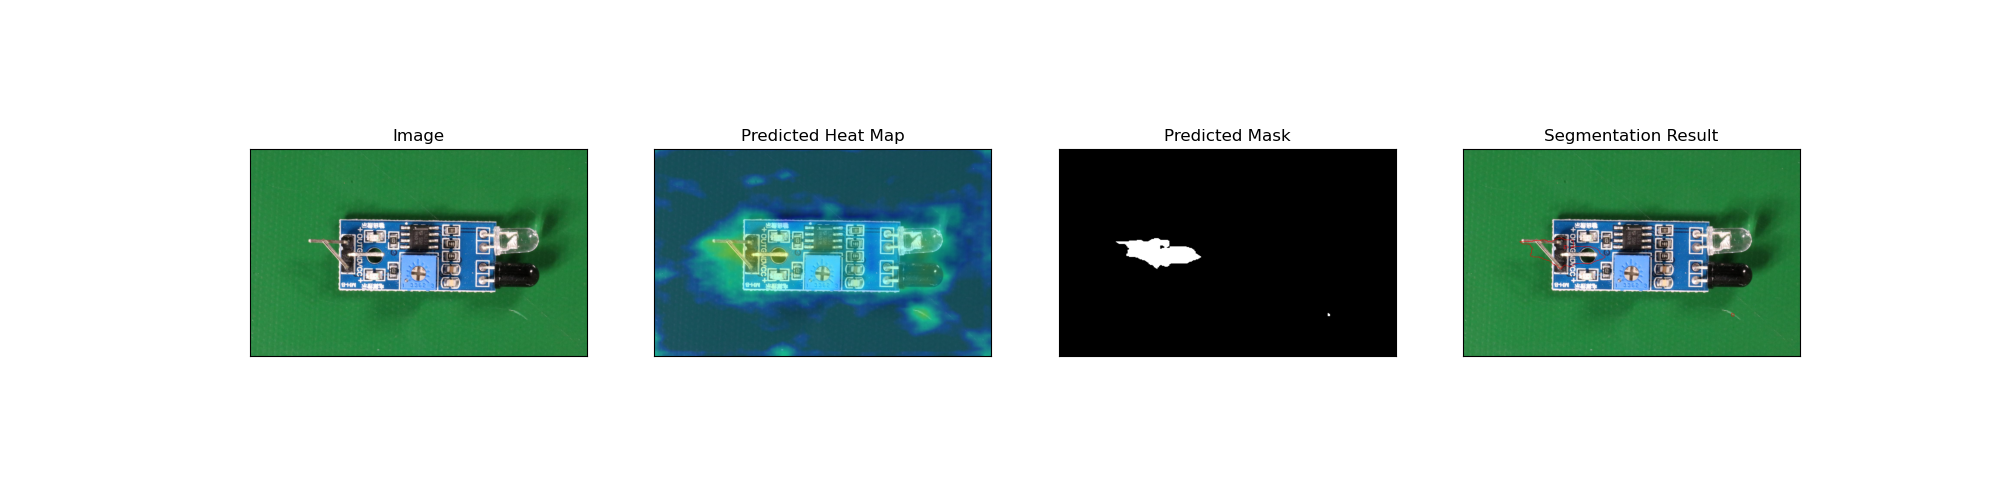

In [15]:
visualizer = Visualizer(mode=VisualizationMode.FULL, task=TaskType.SEGMENTATION)
output_image = visualizer.visualize_image(predictions)
Image.fromarray(output_image)

#### Example 2

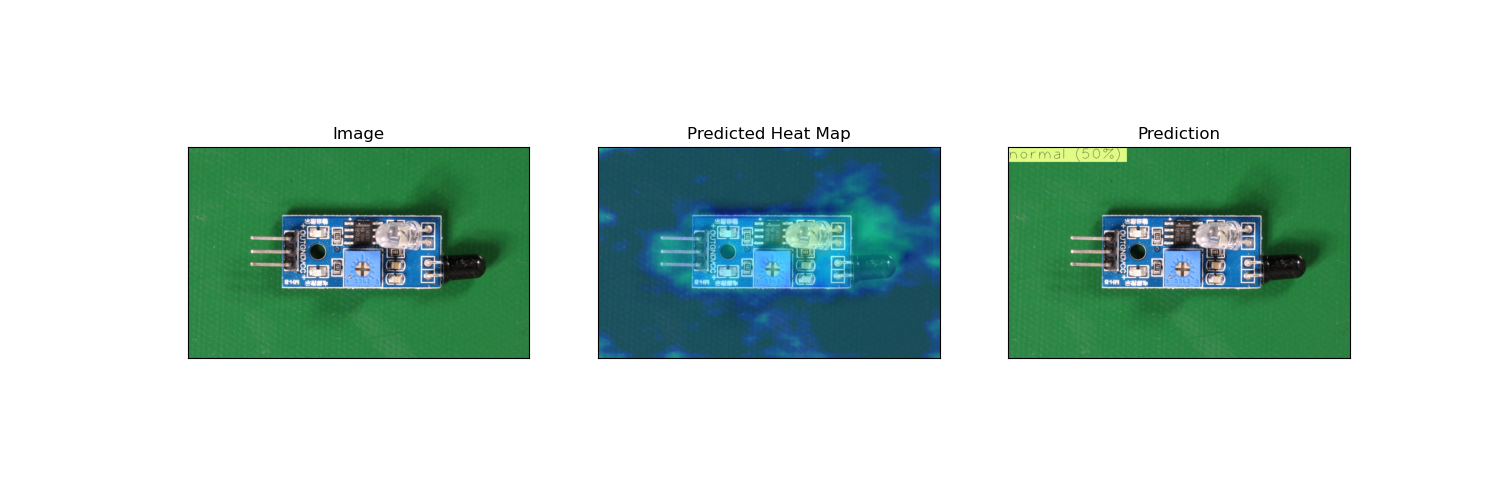

In [16]:
image = read_image(path="./pcb3/anomaly_png/005.png")
predictions = inferencer.predict(image=image)
visualizer = Visualizer(mode=VisualizationMode.FULL, task=TaskType.CLASSIFICATION)
output_image = visualizer.visualize_image(predictions)
Image.fromarray(output_image)

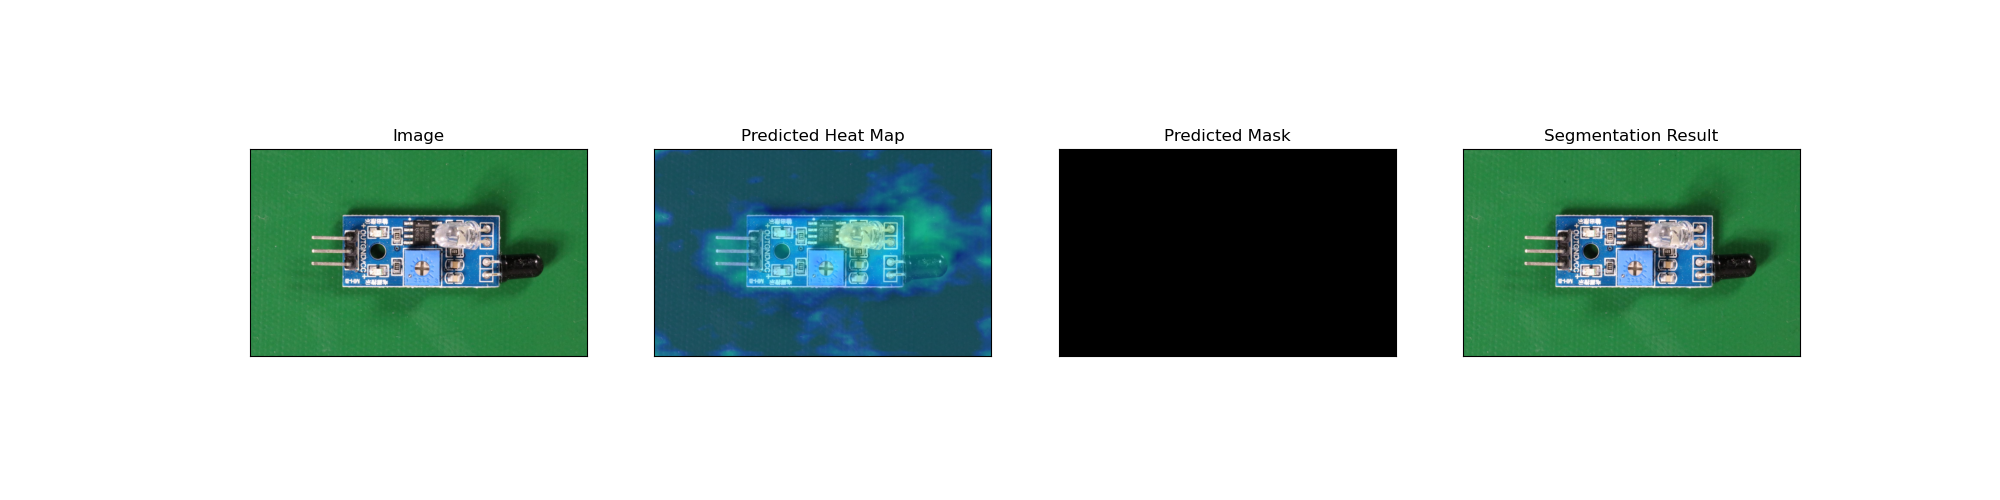

In [17]:
visualizer = Visualizer(mode=VisualizationMode.FULL, task=TaskType.SEGMENTATION)
output_image = visualizer.visualize_image(predictions)
Image.fromarray(output_image)

#### Example 3

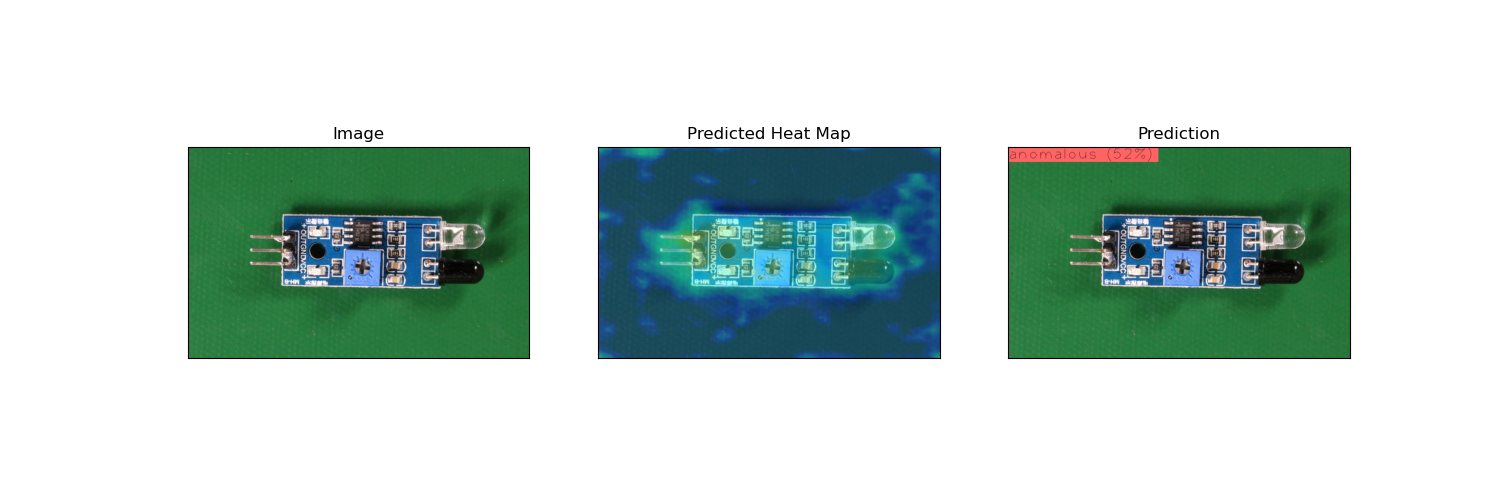

In [18]:
image = read_image(path="./pcb3/anomaly_png/023.png")
predictions = inferencer.predict(image=image)
visualizer = Visualizer(mode=VisualizationMode.FULL, task=TaskType.CLASSIFICATION)
output_image = visualizer.visualize_image(predictions)
Image.fromarray(output_image)

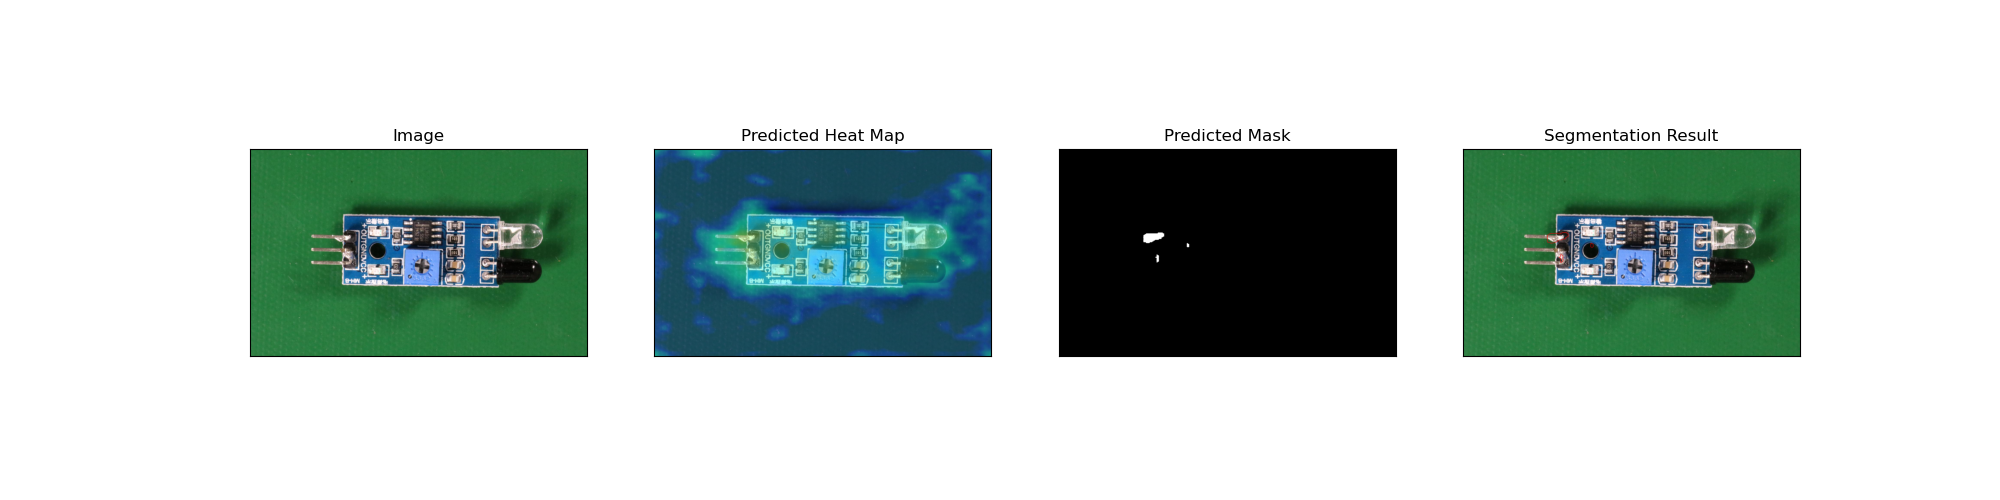

In [19]:
visualizer = Visualizer(mode=VisualizationMode.FULL, task=TaskType.SEGMENTATION)
output_image = visualizer.visualize_image(predictions)
Image.fromarray(output_image)

#### Example 4

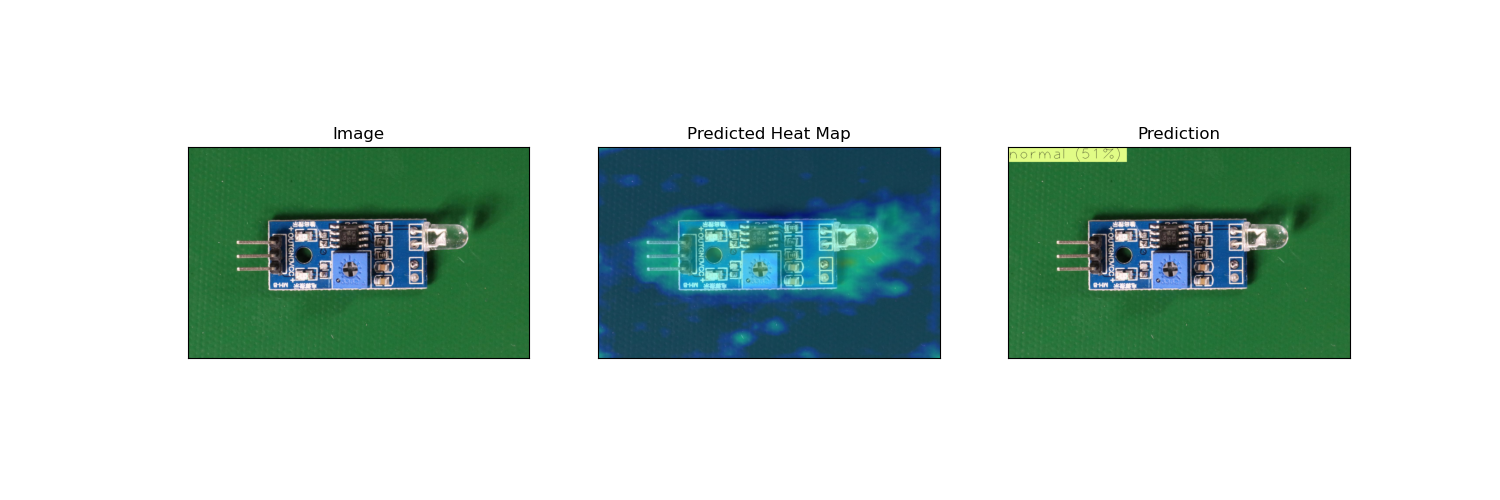

In [20]:
image = read_image(path="./pcb3/anomaly_png/048.png")
predictions = inferencer.predict(image=image)
visualizer = Visualizer(mode=VisualizationMode.FULL, task=TaskType.CLASSIFICATION)
output_image = visualizer.visualize_image(predictions)
Image.fromarray(output_image)

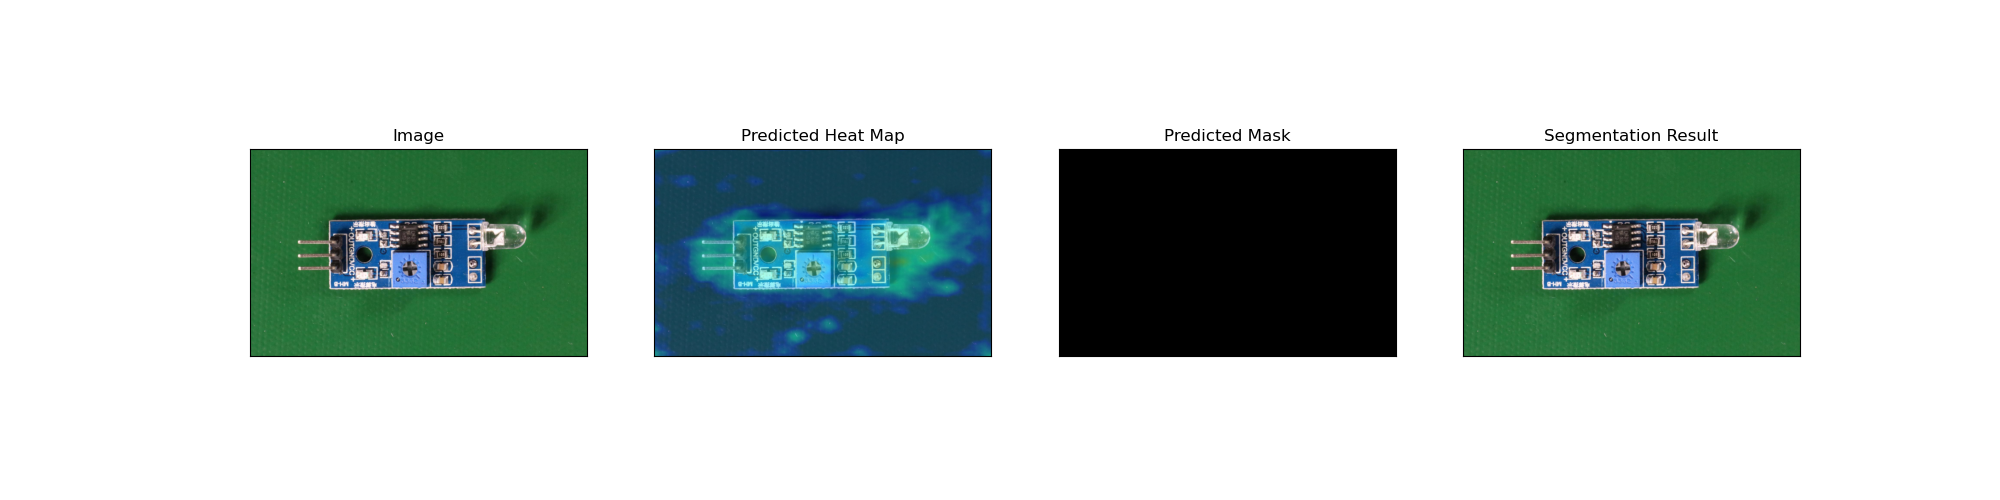

In [21]:
visualizer = Visualizer(mode=VisualizationMode.FULL, task=TaskType.SEGMENTATION)
output_image = visualizer.visualize_image(predictions)
Image.fromarray(output_image)